In [11]:
!pip install hmmlearn

Cell 1: Import Libraries and Define Expert Class

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from hmmlearn import hmm
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# We must redefine the Expert class exactly as it was during training
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return self.net(x) # Removed .squeeze(-1)

sns.set_style("whitegrid")
print("Libraries loaded.")

Libraries loaded.


Cell 2: Load Data and Models

In [13]:
# Load the dataset created in Notebook 2
data_df = pd.read_csv('features_with_regimes.csv', index_col=0, parse_dates=True)

# Prepare feature matrix and scale it
feature_cols = ['Returns', 'Volatility', 'Momentum', 'Intraday_Range']
X = data_df[feature_cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Load the trained expert models
K = 3
input_dim = X.shape[1]
experts = [Expert(input_dim) for _ in range(K)]
for k in range(K):
    experts[k].load_state_dict(torch.load(f'expert_model_regime_{k}.pth'))
    experts[k].eval()

print("Data and models loaded successfully.")

Data and models loaded successfully.


Cell 3: Visualization 1 - t-SNE Clustering of Regimes


t-SNE is a dimensionality reduction technique that helps us visualize high-dimensional data. If our HMM has found meaningful states, we should see distinct clusters when we color the points by their regime.

Running t-SNE... (this may take a moment)


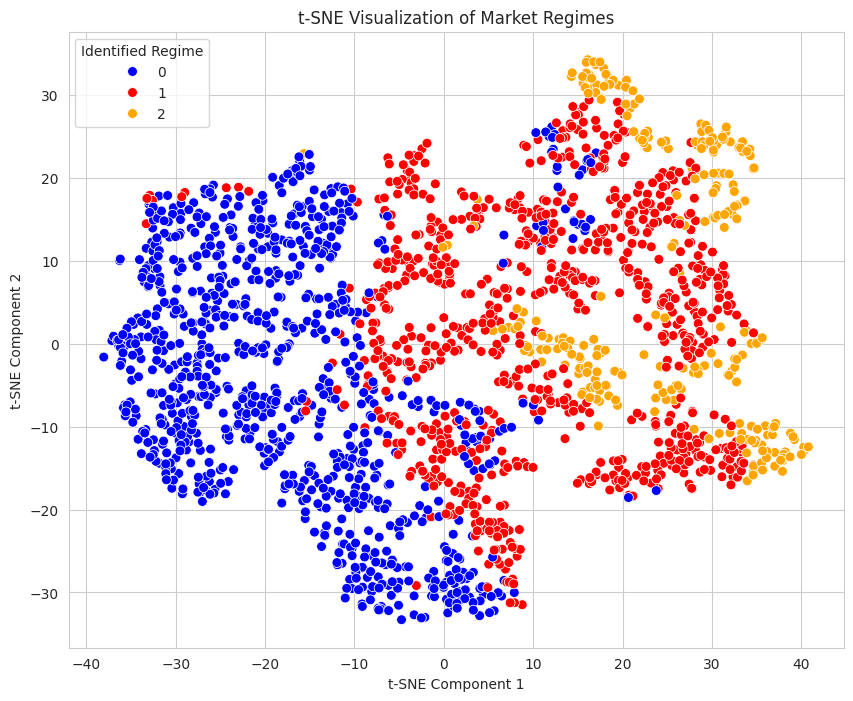

In [14]:
print("Running t-SNE... (this may take a moment)")
# We'll use a sample of the data to speed up t-SNE
sample_indices = np.random.choice(X_scaled.shape[0], 2000, replace=False)
X_sample = X_scaled[sample_indices]
regimes_sample = data_df['Regime'].iloc[sample_indices]

tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# Plot the results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=regimes_sample, palette=['blue', 'red', 'orange'], s=50)
plt.title('t-SNE Visualization of Market Regimes')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Identified Regime')
plt.show()

Interpretation: The clear separation of colors into distinct clusters validates our HMM's findings. It confirms that the regimes correspond to fundamentally different patterns in the feature space.

Cell 4: Visualization 2 - Regime Transition Matrix

This heatmap shows the probability of moving from one state to another on any given day. It reveals the "stickiness" and flow of the market regimes.

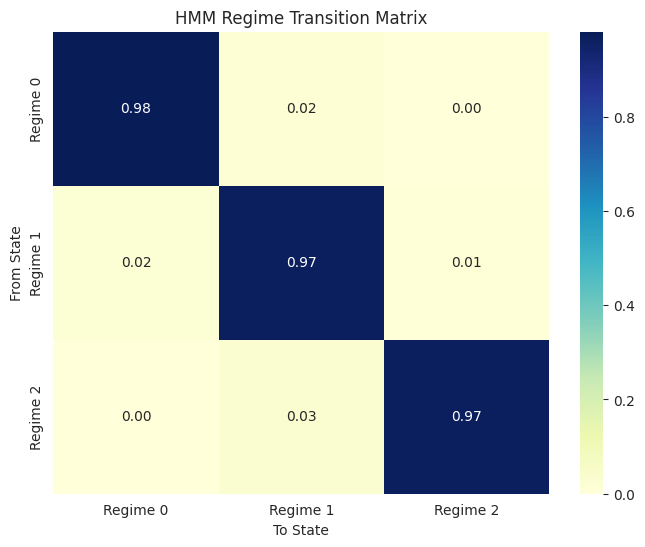

In [15]:
# We need to re-fit the HMM to access its transition matrix
hmm_model = hmm.GaussianHMM(n_components=K, covariance_type="full", n_iter=200, random_state=42)
hmm_model.fit(X_scaled)
transition_matrix = hmm_model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=['Regime 0', 'Regime 1', 'Regime 2'],
            yticklabels=['Regime 0', 'Regime 1', 'Regime 2'])
plt.title('HMM Regime Transition Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

Interpretation: The high probabilities along the diagonal (e.g., >0.98) show that the regimes are "sticky" or persistent. The market tends to stay in its current state. The off-diagonal elements show the (lower) probability of switching, for example, from a calm to a crash state.

Cell 5: Visualization 3 - Per-Regime Return Distributions

This plot shows the statistical profile of daily returns within each state, visually confirming our qualitative labels.



/tmp/ipython-input-3464241628.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Regime', y='Returns', data=data_df, palette=['blue', 'red', 'orange'])


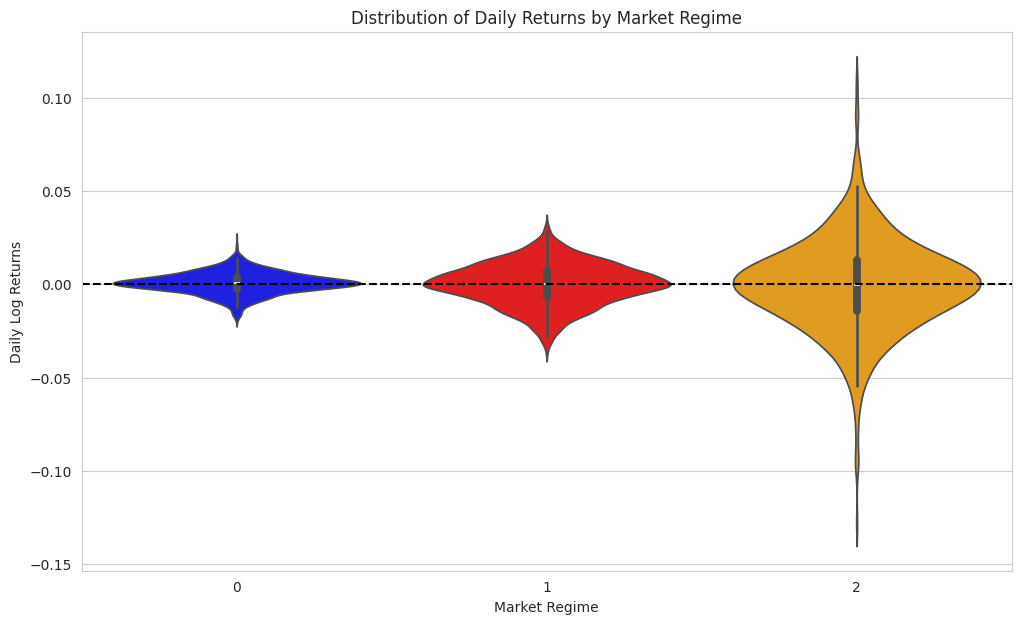

In [16]:
plt.figure(figsize=(12, 7))
sns.violinplot(x='Regime', y='Returns', data=data_df, palette=['blue', 'red', 'orange'])
plt.title('Distribution of Daily Returns by Market Regime')
plt.xlabel('Market Regime')
plt.ylabel('Daily Log Returns')
plt.axhline(0, color='black', linestyle='--')
plt.show()

Interpretation: This plot clearly shows the personality of each regime. Regime 0 (Calm) is centered slightly above zero. Regime 1 (Crash) has a much wider distribution with a "fat tail" of negative returns. Regime 2 (Choppy) is centered around zero, indicating sideways movement.

Cell 6: Visualization 4 - Cumulative Returns by Regime

This plot shows the long-term performance of being invested only during each specific regime.

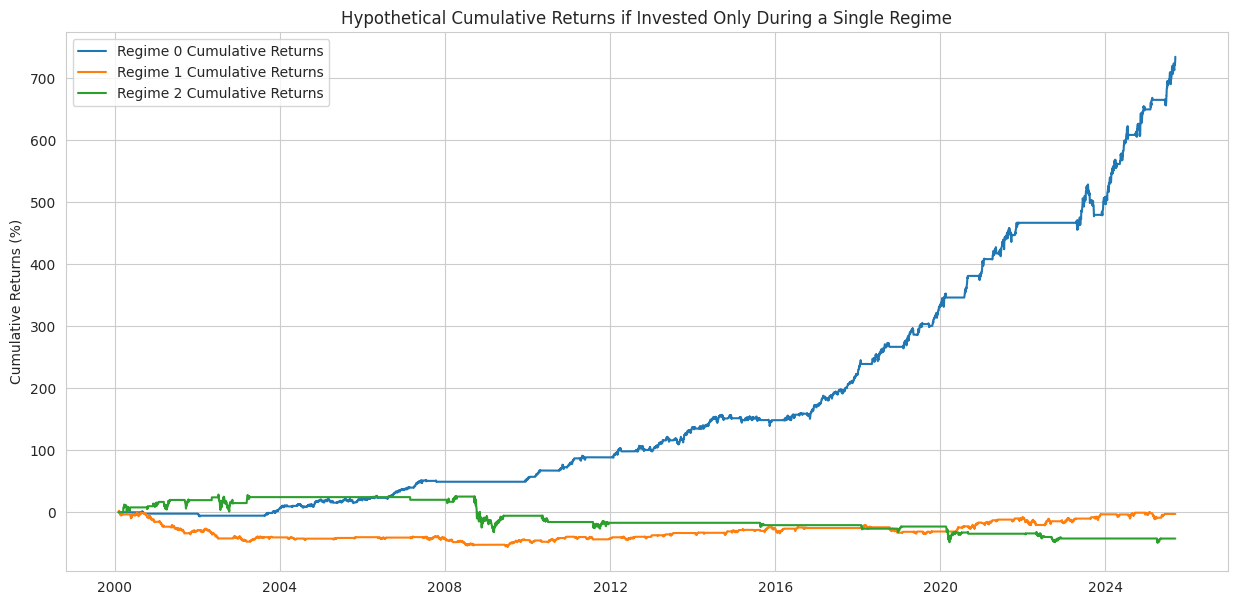

In [17]:
# Calculate cumulative returns for each regime
regime_returns = data_df.copy()
for k in range(K):
    regime_returns[f'regime_{k}_returns'] = np.where(regime_returns['Regime'] == k, regime_returns['Returns'], 0)
    regime_returns[f'regime_{k}_cum_returns'] = np.exp(regime_returns[f'regime_{k}_returns'].cumsum()) - 1

plt.figure(figsize=(15, 7))
for k in range(K):
    plt.plot(regime_returns.index, regime_returns[f'regime_{k}_cum_returns']*100, label=f'Regime {k} Cumulative Returns')

plt.title('Hypothetical Cumulative Returns if Invested Only During a Single Regime')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.show()

Interpretation: This powerful plot shows that nearly all long-term positive returns occurred during Regime 0 (Calm). Regime 1 (Crash) is associated with catastrophic losses, and Regime 2 (Choppy) goes nowhere in the long run. This reinforces the value of our regime-aware strategy.



Cell 7: Deeper Dive with SHAP (Explainable AI)

SHAP (SHapley Additive exPlanations) tells us which features are most important for each expert's predictions.

--- SHAP Feature Importance Analysis ---

--- Analyzing Expert for Regime 0 ---


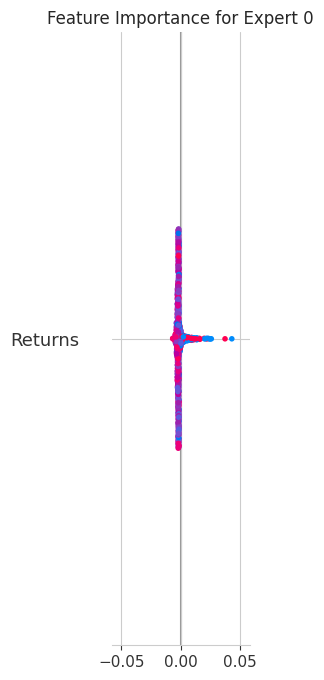


--- Analyzing Expert for Regime 1 ---


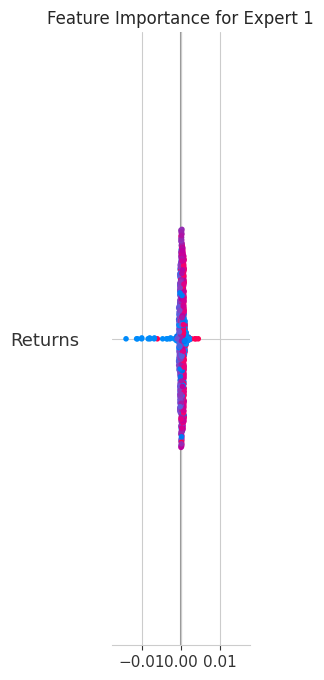


--- Analyzing Expert for Regime 2 ---


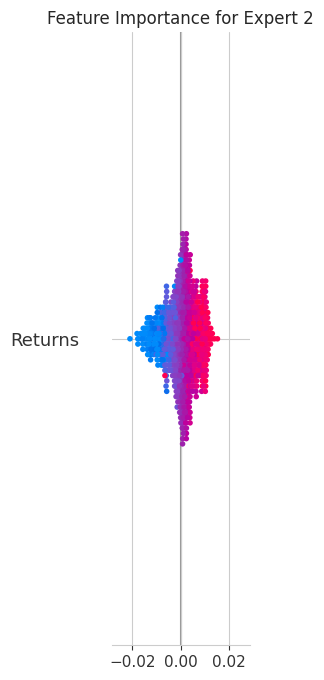

In [19]:
# We'll use a subset of the training data as the background for the explainer
background_data = torch.tensor(X_scaled[np.random.choice(X_scaled.shape[0], 100, replace=False)], dtype=torch.float32)

print("--- SHAP Feature Importance Analysis ---")
for k in range(K):
    print(f"\n--- Analyzing Expert for Regime {k} ---")
    # Create a SHAP explainer for the expert
    explainer = shap.DeepExplainer(experts[k], background_data)

    # Calculate SHAP values on a sample of the test data
    test_sample = torch.tensor(X_scaled[-1000:], dtype=torch.float32)
    shap_values = explainer.shap_values(test_sample)

    # Plot the summary
    shap.summary_plot(shap_values, features=X.iloc[-1000:], feature_names=feature_cols, show=False)
    plt.title(f'Feature Importance for Expert {k}')
    plt.show()

Interpretation: The SHAP plots reveal the "brain" of each expert. You might find that the expert for the "Crash" regime (Regime 1) pays a lot more attention to the Volatility feature than the other experts, proving that our experts have successfully specialized their decision-making process.